In [23]:
import numpy as np
from graph_tool.all import *
from scipy.stats import expon as expon
from scipy.stats import poisson as pois
from scipy.stats import zipf as zipf_distr
from scipy.stats import norm as snorm
import graph_tool.generation as gt
from copy import deepcopy as cp
from scipy import integrate as integr
import time
import scipy
import itertools
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [ ]:
?integr.odeint

In [ ]:
def solvr(Y, t):
    return [Y[1], -2 * Y[0]-Y[1]]

In [ ]:
a_t = np.arange(0, 25.0, 0.01)
asol = integr.odeint(solvr, [1, 0], a_t)

In [ ]:
def solvr(Y, t):
    return t

In [ ]:
a_t = np.arange(1, 10, 0.01)
sol = integr.odeint(solvr, 50, a_t)
plt.plot(a_t, sol)

# Надо сделать:
-Научиться генерировать граф с заданным распределением на степени вершин - ОК    
-Дать каждой вершине +1 или -1 с заданными долями в зависимости от степени, или случайно - ОК   
-Визуализировать текущую ситуацию - ОК   
-Сделать шаг пересчета - ОК  
-Написать функцию для вычисления среднего поля и парных корелляций - ОК  
-Разбить вершины по квантилям на 3 группы в зависимости от степени - ОК  
-Написать генерацию степеней для пуассоновского распределения и степенного для k - параметр - ОК    
-Написать реализацию пуассоновских часов - ОК   
-Найти начиная с какого количества ребер происходит сходимость всех к одной стороне  
-Найти зависимость сходимости от $\sigma$ в нормальном распределении для разности шума  
-Переделать F для разности двух гауссовых распределений - ОК    
-Найти зависимость сходимости от $\sigma$ для конкретных графов двух типов

# 1. Основные функции

## 1.1 Функция распределения степеней вершин

In [20]:
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]

## 1.2 Функция генерации графа

In [125]:
def gen_graph():
    g = gt.random_graph(SIZE, get_vertex_degree, directed=False)
    labels = g.new_vertex_property("int")
    weighted_total = g.new_graph_property("vector<double>")
    revise_times = g.new_graph_property("vector<double>")
    k_mean = g.new_graph_property("double")
    
    g.graph_properties["m_w"] = weighted_total
    g.graph_properties["times"] = revise_times
    g.graph_properties["k_mean"] = k_mean
    
#    labels_mean = g.new_vertex_property("vector<int>")  
    vertices = [item for item in g.vertices()]
    
    # начальное распределение на вершины
    for vertex in vertices:
        labels[vertex] = np.random.binomial(1, 0.5, 1) * 2 - 1
#        labels_mean[vertex].append(0)
    # среднее значение степени вершины
    k_mean[g] = np.mean([g.degree_property_map('out')[v] for v in g.vertices()])
    revise_times[g].append(0)
    weight = 1.0 * np.sum([labels[v]*g.degree_property_map('out')[v] for v in g.vertices()])
    weight /= SIZE
    weight /= k_mean[g]
    weighted_total[g].append(weight)
    
    pos = graph_tool.draw.sfdp_layout(g)
    
    return g, labels, pos

## 1.3 Инициализирующие параметры и начальный граф

In [40]:
SIZE = 500
GTYPE = 'zipf'
g, labels, _ = gen_graph()
vert_degrees = np.array([g.degree_property_map('out')[v] for v in g.vertices()])

In [33]:
res = np.unique(vert_degrees)
print res

[  1   2   3   4   5   7   8   9  10  11  12  13  14  41  45  54 173]


In [126]:
SIZE = 500
GTYPE = 'pois'
g, labels, _ = gen_graph()

In [130]:
print g.graph_properties["k_mean"]
print g.graph_properties["times"]
print g.graph_properties["m_w"]

50.768
array([ 0.])
array([-0.00456981])


## 1.4 Функция для вычисления порядка в котором агенты пересматривают свои решения.
##### Вход:  
-суммарное количество агентов  
-суммарное количество пересмотров  
##### Выход:
-список из агентов в порядке очереди пересчета и времена пересчетов

In [104]:
def get_queue(revisions_number, agents_number=SIZE):
    k = int(revisions_number / agents_number) + 1
    calc_times = expon.rvs(size = agents_number*k)
    
    pairs_time_number = [[calc_times[i], i] for i in range(agents_number)]
    for j in range(k-1):
        l = [[calc_times[i+j*agents_number] + pairs_time_number[i + j*agents_number][0], i] for i in range(agents_number)]
        pairs_time_number += l
    
    pairs_time_number.sort()
    
    queue = [pairs_time_number[i][1] for i in range(revisions_number)]
    calc_times = [pairs_time_number[i][0] for i in range(revisions_number)]
    return queue, calc_times

In [103]:
get_queue(10, 3)

([0, 1, 0, 1, 2, 1, 1, 0, 2, 2],
 [0.13266662332897303,
  0.15068368216240474,
  0.26533324665794605,
  0.30136736432480948,
  1.0918299743176407,
  1.2001430441746281,
  1.5396897798124025,
  2.0750216762692024,
  2.1836599486352815,
  2.7818636758672071])

## 1.5 Функция распределения для $\varepsilon(1) - \varepsilon(-1)$

Каждая $\varepsilon$ распределена нормально, значит $\varepsilon(1) - \varepsilon(-1) = \varepsilon(1) + (- \varepsilon(-1))$$. Сумма двух нормальных величин - нормальная величина с суммарной дисперсией

In [136]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)

## 1.6 Функция для обновления меток на основании полезности

Переходная условная вероятность имеет вид  
$P(w_{it+} = 1| w_t) = F(2h + 2 \frac{J}{I-1} \sum\limits_{j \ne i} w_{jt}$), где   
$w_{it+}$ - выбор $i$-того агента в момент времени $t+1$  
$2h$ - коэффициент индивидуальной полезности, в программе $private \text{ } utility$  
$2 \frac{J}{I-1}$ - коэффициент полезности соответствия соседям, в программе $pairwise \text{ } utitily$  

In [132]:
def revise_label(agent_number, time, g=g, labels=labels, size=SIZE, cdf=cdf):
    private_utility = 0.0
    pairwise_utitily = 1.0
    v = g.vertex(agent_number)
    g.graph_properties["times"].append(time)
    prev_label = labels[v]
        
    neighbours = [item for item in v.out_neighbours()]
    neighbours_sum = np.sum([labels[v_neighb] for v_neighb in neighbours])
    prob = cdf(private_utility + pairwise_utitily*neighbours_sum)
    
    labels[v] = np.random.binomial(1, prob, 1) * 2 - 1
    
    delta_m_w = 1.0*(labels[v] - prev_label) * g.degree_property_map('out')[v] / g.graph_properties["k_mean"] / size
    g.graph_properties["m_w"].append(g.graph_properties["m_w"][-1] + delta_m_w)
#    labels_mean[v].append(2*prob - 1)

## 1.7 Функция для вычисления текущего среднего поля и парных корелляций

Функция разбивает вершины в зависимости от степени на $k$ групп (по квантилям) и возвращает пару из массива средних значений меток длины $k$ и матрицу парных корреляций размера $k*k$

In [10]:
def calc_cur_stats(k=3, g=g, labels=labels):
    # параллельные списки из меток и степеней вершин
    vert_labels = np.array([labels[v] for v in g.vertices()])
    vert_degrees = np.array([g.degree_property_map('out')[v] for v in g.vertices()])
    vert_groups = np.zeros(len(vert_degrees)+1)
    # Определяем границы для разделения вершин по степеням на k групп
    bounds = [-1.0]
    for i in range(k-1):
        bounds.append(np.percentile(vert_degrees, 100.0 * (i+1) / k))
    
    bounds.append(np.max(vert_degrees))
    
    # Задаем группы вершинам в зависимости от степени
    
    # Создаем итоговые статистики: Средние метки
    mean_fields = []
    for i in range(k):
        indexes = np.array(vert_degrees > bounds[i]) * np.array(vert_degrees <= bounds[i+1])
        # Задаем группы вершинам в зависимости от степени
        vert_groups[indexes] = i
        mean_fields.append(np.mean(vert_labels[indexes]))
#        print len(bounded_labels)

    # Создаем итоговые статистики: Средние парные корелляции
    pair_corr = dict()
    for i in range(k):
        for j in range(k):
            pair_corr[(i, j)] = []
    for edge in g.edges():
        matr_index = (vert_groups[int(edge.source())], vert_groups[int(edge.target())])
        matr_index_inv = (matr_index[1], matr_index[0])
        
        matr_value = vert_labels[int(edge.source())] * vert_labels[int(edge.target())]
        
        pair_corr[matr_index].append(matr_value)
        pair_corr[matr_index_inv].append(matr_value)
    
    pair_corr_matr = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            pair_corr_matr[i, j] = np.mean(pair_corr[(i, j)])
    return mean_fields, pair_corr_matr

## 1.8 Функция для вычисления $m_w$

# 2. Решения дифуров

## 2.1 Решение (37) для $m_w$

In [137]:
def g_func(x):
    return np.log(cdf(x)) - np.log(1 - cdf(x))

In [138]:
def derivative_m_w(m, t):
    vert_degrees = np.array([g.degree_property_map('out')[v] for v in g.vertices()])
    k_mean = np.mean(vert_degrees)
    k_max = np.max(vert_degrees)
    sum_k = 0
    for k in range(k_max + 1):
        p_k = 1.0 * np.sum(vert_degrees == k) / SIZE
        if (p_k != 0):
            koef = np.tanh(0.5*g_func(1.0*k*m))
            sum_k += k * p_k * koef
    sum_k /= k_mean
    return sum_k - m

In [139]:
def calc_start_m_w():
    vert_degrees = np.array([g.degree_property_map('out')[v] for v in g.vertices()])
    vert_labels = np.array([labels[v] for v in g.vertices()])
    k_mean = np.mean(vert_degrees)
    
    m_w = 0.0
    for i in range(len(vert_labels)):
        m_w += vert_degrees[i]*vert_labels[i]
    m_w /= SIZE
    m_w /= k_mean
    return m_w

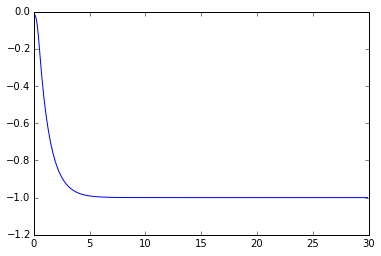

In [119]:
a_t = np.arange(0, 30, 0.1)
sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
plt.plot(a_t, sol)

In [ ]:
vert_labels = np.array([labels[v] for v in g.vertices()])
print np.mean(vert_labels)

In [ ]:
c = calc_start_m_w(10)
print c

## Функция для тестов

#### Принимает:  
-размер очереди (количество обновлений меток между замерами)  
-количество замеров  
-количество повторений тестов  
-на сколько частей делить вершины по степеням  
-измеряемый параметр (среднее поле\парные корреляции)

In [134]:
def test(queue_size, evo_points, test_number=5, parts_number=3, param='mean', cdf=cdf):
    for i in range(test_number):
        print "Start iteration ", i+1, " of ", test_number
        g, labels, _ = gen_graph()
        
        res = []
        if param == 'mean':
            for j in range(parts_number+1):
                res.append([])
            for step in range(evo_points):
                queue, times = get_queue(queue_size, SIZE)
                for idx in range(len(queue)):
                    revise_label(queue[idx], times[idx], g, labels, SIZE, cdf)
                temp, corr = calc_cur_stats(3, g=g, labels=labels)

                for j in range(len(temp)):
                    res[j].append(temp[j])
                res[3].append(np.mean(temp))

            figure(figsize = (15, 4))
            plt.plot(res[0], label="low")
            plt.plot(res[1], label="medium")
            plt.plot(res[2], label="high")
        #    plt.plot(res[3], label="superHigh")

            plt.plot(res[3], label="mean", color='black')
            plt.legend(loc='best')

    # Пока что реализация для parts_number = 3
        if param == 'corr':
            for j in range(6):
                res.append([])
            for step in range(evo_points):
                queue = get_queue(queue_size, SIZE)[0]
                for vert_index in queue:
                    revise_label(vert_index, g, labels, SIZE, cdf)

                _, corr = calc_cur_stats(3, g=g, labels=labels)

                for i in range(3):
                    res[i].append(corr[i, i])

                res[3].append(corr[0, 1])
                res[4].append(corr[0, 2])
                res[5].append(corr[1, 2])

            figure(figsize = (15, 4))
            plt.plot(res[0], label="low_low")
            plt.plot(res[1], label="medium_medium")
            plt.plot(res[2], label="high_high")
            plt.legend(loc='best')

            figure(figsize = (15, 4))
            plt.plot(res[3], label="low_medium")
            plt.plot(res[4], label="low_high")
            plt.plot(res[5], label="medium_high")
            plt.legend(loc='best')

## Зависимость сходимости от $\sigma$ в нормальном распределении

In [ ]:
SIZE = 500
GTYPE = 'pois'

In [ ]:
def test_stability(queue_size=10, evo_points=200, test_number=1, parts_number=3, eps = 0.01, cdf=cdf):
    g, labels, _ = gen_graph()
    for i in range(test_number):
        print "Start iteration ", i+1, " of ", test_number
        g, labels, _ = gen_graph()

        res = []
        for j in range(parts_number+1):
            res.append([])
        for step in range(evo_points):
            queue = get_queue(queue_size, SIZE)[0]
            for vert_index in queue:
                revise_label(vert_index, g, labels, SIZE, cdf)
            temp, corr = calc_cur_stats(3, g=g, labels=labels)

            for j in range(len(temp)):
                res[j].append(temp[j])
            res[len(temp)].append(np.mean(temp))

        stables = [[],[],[]]
        for i in range(parts_number):
            for j in range(len(res[i])):
                if np.abs(res[i][j]) + eps > 1:
                    stables[i].append(np.sign(res[i][j]))
                else:
                    stables[i].append(0)

        for i in range(parts_number):
            for j in range(len(stables[i])):
                if (stables[i][j] != 0):
                    print "size = ", i, j, " first of ", len(stables[i]), "var after = ", np.var(stables[i][j:])
                    break

        figure(figsize = (15, 4))
        plt.plot(res[0], label="low")
        plt.plot(res[1], label="medium")
        plt.plot(res[2], label="high")

        plt.plot(res[3], label="mean", color='black')
        plt.legend(loc='best')

In [168]:
SIZE = 500
GTYPE = 'pois'
queue_size = 1000
g, labels, _ = gen_graph()
g_copy = cp(g)

In [169]:
calc_start_m_w()

-0.032007130702536267

In [170]:
queue, times = get_queue(queue_size, SIZE)
for i in range(len(queue)):
    revise_label(queue[i], times[i], g, labels, SIZE, cdf)
a_t = np.array(g.graph_properties["times"])

In [171]:
g = g_copy
g.graph_properties["times"]
calc_start_m_w()

-0.85973583988331581

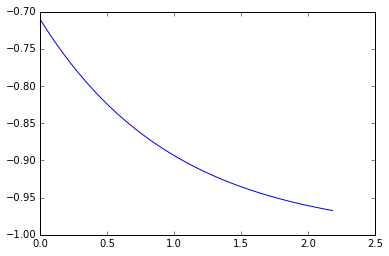

In [163]:
#a_t = np.arange(0, 30, 0.1)
sol = integr.odeint(derivative_m_w, calc_start_m_w(), a_t)
plt.plot(a_t, sol)

In [151]:
print type(a_t)

<type 'numpy.ndarray'>


In [ ]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=5)
test_stability(queue_size=50, evo_points=100, test_number=1, parts_number=3, eps = 0.01, cdf=cdf)

In [ ]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=6)
test_stability(queue_size=50, evo_points=100, test_number=1, parts_number=3, eps = 0.01, cdf=cdf)

In [ ]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=7)
test_stability(queue_size=100, evo_points=100, test_number=1, parts_number=3, eps = 0.01, cdf=cdf)

In [ ]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=8)
test_stability(queue_size=100, evo_points=100, test_number=1, parts_number=3, eps = 0.01, cdf=cdf)

In [ ]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=9)
test_stability(queue_size=100, evo_points=100, test_number=1, parts_number=3, eps = 0.01, cdf=cdf)

In [ ]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=10)
test_stability(queue_size=100, evo_points=100, test_number=1, parts_number=3, eps = 0.01, cdf=cdf)

In [ ]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=12)
test_stability(queue_size=100, evo_points=100, test_number=1, parts_number=3, eps = 0.01, cdf=cdf)

In [ ]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=14)
test_stability(queue_size=100, evo_points=100, test_number=1, parts_number=3, eps = 0.01, cdf=cdf)

In [ ]:
def cdf(delta_utility):
    return snorm.cdf(delta_utility, loc=0.0, scale=14)
test_stability(queue_size=100, evo_points=1000, test_number=1, parts_number=3, eps = 0.01, cdf=cdf)

In [ ]:
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.05, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    if GTYPE == 'zipf':
        return zipf_distr.rvs(2.5, loc=0, size=1, random_state=None)[0]
test_stability(queue_size=30, evo_points=200, test_number=1, parts_number=3, eps = 0.01)

## 50 вершин, мало ребер
Протестируем на малом графе

In [ ]:
SIZE = 50
GTYPE = 'pois'
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

Агенты ведут себя крайне не стабильно, даже после почти полного доминирования одного из решений, достаточная доля агентов меняла общепринятое на противоположное. Соседей мало, поэтому этого влияния не достаточно, чтобы подавить случайную компоненту.

Попробуем увеличить число ребер в маленьком по числу вершин графе, переопределив генерирующую функцию

## 50 вершин, много ребер

In [ ]:
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.5, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
    

In [ ]:
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

## 50 вершин, среднее число ребер

In [ ]:
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.2, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

In [ ]:
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.3, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

При средней степени вершины >10 наблюдается стабильность у средне и высоко степенных вершин

## 100 вершин, мало ребер

Start iteration  1  of  5
Start iteration  2  of  5
Start iteration  3  of  5
Start iteration  4  of  5
Start iteration  5  of  5


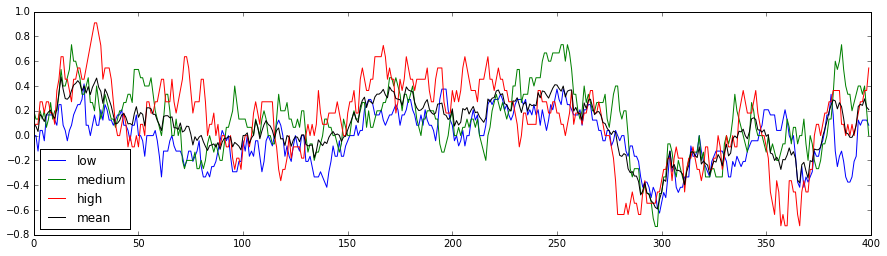

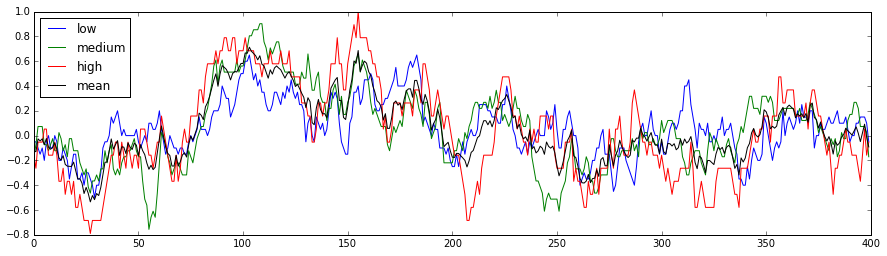

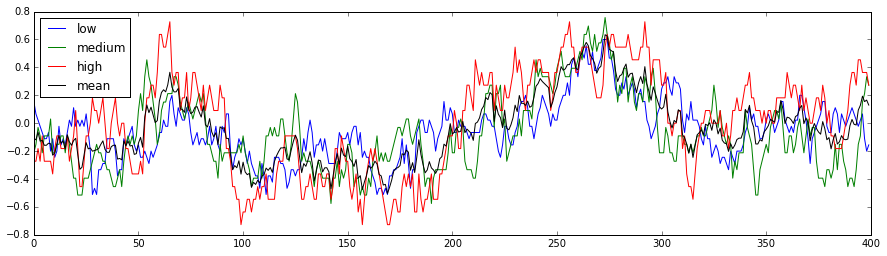

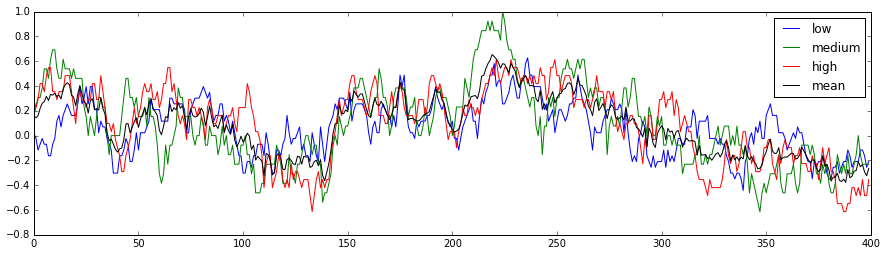

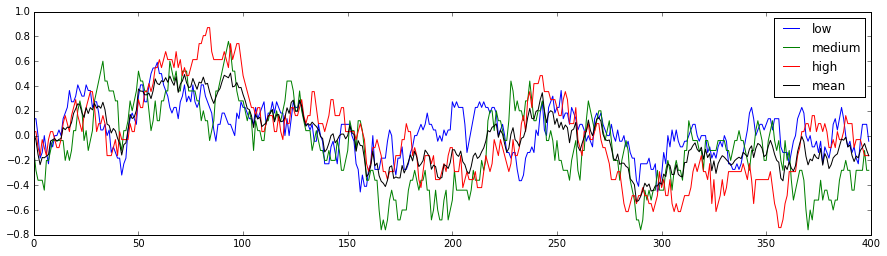

In [19]:
SIZE = 100
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.05, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=20, evo_points=400, test_number=5, parts_number=3, param='mean', cdf=cdf )

Наблюдаем интересный эффект: естесственно вершины большой степени стремятся к крайним значениям среднего в зависимости от интегрального среднего поля, но из-за малого числа ребер, эти крайние значения могут меняться в процессе эволюции

In [ ]:
SIZE = 100
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.08, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

In [ ]:
SIZE = 100
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

In [ ]:
SIZE = 100
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.2, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

## 200 вершин, мало ребер

In [ ]:
SIZE = 200
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.05, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=20, evo_points=200, test_number=5, parts_number=3 )


In [ ]:
SIZE = 200
GTYPE = 'pois'
def get_vertex_degree():
    if GTYPE == 'pois':
        return pois.rvs(SIZE*0.1, 0, 1)[0]
    if GTYPE == 'randint':
        return np.random.randint(10)
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )
test(queue_size=10, evo_points=200, test_number=5, parts_number=3 )

## Графики для корреляций 200 вершин, пуассоновский граф

In [ ]:
test(queue_size=10, evo_points=200, test_number=5, parts_number=3, param='corr')

## Большой граф
1000 вершин, средняя степень ~100

In [ ]:
test(queue_size=500, evo_points=200, test_number=20, parts_number=3 )

In [ ]:
print calc_statistics(3)